### Performing Imports

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline
!pip install langdetect
from langdetect import detect
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, cohen_kappa_score
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from bs4 import BeautifulSoup
from google.colab import drive
from sklearn import metrics
import warnings
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Reading in the Labeled Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
excel_file_path = "/content/drive/My Drive/YAZreviews_correct_version.xlsx"
df = pd.read_excel(excel_file_path)
df.head(3)

,Review,Condition,Overall Ratings,Effectiveness,Ease of Use,Satisfaction,Rachel,Longyang,Lu,Ibrahim,Aleyeh
0,I was taking for PMDD or PME like symptoms. I'...,Premenstrual Disorder with a State of Unhappiness,1.0,1,1,1,-1.0,NaN,-1.0,NaN,-1.0
1,I had a very bad reaction to Yaz. Within 2 wee...,Premenstrual Disorder with a State of Unhappiness,2.3,1,5,1,-1.0,NaN,-1.0,NaN,-1.0
2,After dealing with hormonal acne for about 2 y...,Acne,5.0,5,5,5,1.0,NaN,1.0,NaN,1.0


### Confirm if each review was labelled by three reviewers

In [ ]:
# Calculate the total number of labels for each record
df['Total_Labels'] = df[['Rachel', 'Longyang', 'Lu', 'Ibrahim', 'Aleyeh']].notnull().sum(axis=1)

# Check if each record has been labeled by exactly three people
if (df['Total_Labels'] == 3).all():
    print("Each record has been labeled by exactly three people.")
else:
    records_not_labeled_by_three = df[df['Total_Labels'] != 3]
    records_not_labeled_by_three.reset_index(drop=True, inplace=True)
    count_records_not_labeled_by_three = len(records_not_labeled_by_three)
    print("Number of records labeled by not exactly three people:", count_records_not_labeled_by_three)
    display(records_not_labeled_by_three)
df.drop(columns=['Total_Labels'], inplace=True)

Each record has been labeled by exactly three people.


### Combining Labels

In [ ]:
raters = ['Rachel', 'Longyang', 'Lu', 'Ibrahim', 'Aleyeh']

def convert_to_int(value):
    return int(value) if not pd.isnull(value) else np.nan

for rater in raters:
    df[rater] = df[rater].apply(convert_to_int)

df['Labels'] = df.apply(lambda row: [row[rater] for rater in raters if not pd.isnull(row[rater])], axis=1)

for i in range(3):
    df[f'Label {i+1}'] = df['Labels'].apply(lambda labels: labels[i] if len(labels) > i else np.nan)

df.drop(columns=['Labels'], inplace=True)
df.sample(5)

,Review,Condition,Overall Ratings,Effectiveness,Ease of Use,Satisfaction,Rachel,Longyang,Lu,Ibrahim,Aleyeh,Label 1,Label 2,Label 3
625,"Well, I didn't get pregnant! Loved the discree...",Birth Control,2.3,3,5,4,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0
108,i haven't used this drug but my friend at age ...,Other,1.0,1,1,1,-1.0,NaN,-1.0,NaN,-1.0,-1.0,-1.0,-1.0
346,Start taken Yasmin in the beginning of May. Ju...,Birth Control,3.0,1,1,1,NaN,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0
632,"Yaz is horrible. I couldn't sleep, gained weig...",Acne,2.3,1,3,1,-1.0,-1.0,NaN,-1.0,NaN,-1.0,-1.0,-1.0
643,WORST EXPERIENCE EVER! I felt extreme anxiety;...,Birth Control,4.0,5,4,1,-1.0,-1.0,NaN,-1.0,NaN,-1.0,-1.0,-1.0


### Calculating Labeling Concordance

In [ ]:
labels = df[['Label 1', 'Label 2', 'Label 3']].values
kappa_score = cohen_kappa_score(labels[:,0], labels[:,1])
print("Cohen's kappa score:", kappa_score)

Cohen's kappa score: 0.8163481850890816


In [ ]:
all_different_records = df[(df['Label 1'] != df['Label 2']) & (df['Label 2'] != df['Label 3']) & (df['Label 1'] != df['Label 3'])]
if not all_different_records.empty:
    print("Records where all labels are different:")
    display(all_different_records)
else:
    # Count of records where all labels are the same
    same_count = df[(df['Label 1'] == df['Label 2']) & (df['Label 2'] == df['Label 3'])]
    same_count = len(same_count)

    # Count of records where exactly two labels are the same
    two_same_count = len(df) - same_count

    print("Count of records where all labels are the same:", same_count)
    print("Count of records where exactly two labels are the same:", two_same_count)

Count of records where all labels are the same: 615
Count of records where exactly two labels are the same: 108


### Choosing the Modal Label as the Final Label

In [ ]:
df['Final Label'] = df[['Label 1', 'Label 2', 'Label 3']].mode(axis=1)[0]
df.sample(5)

,Review,Condition,Overall Ratings,Effectiveness,Ease of Use,Satisfaction,Rachel,Longyang,Lu,Ibrahim,Aleyeh,Label 1,Label 2,Label 3,Final Label
373,Thank God for this website; I thought I was ou...,Birth Control,4.7,4,5,1,NaN,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
219,I loved YAZ. I did have to get my gallbladder...,Disease of Ovaries with Cysts,5.0,5,3,4,NaN,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
100,I have been taking birth control pills for ove...,Birth Control,5.0,5,5,5,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,1.0
680,Decided to try YAZ after my PMS symptoms have ...,Premenstrual Disorder with a State of Unhappiness,5.0,5,5,5,0.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,1.0
717,This has worked wonders for my premenstrual di...,Birth Control,1.0,5,4,5,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0


Top 15 frequent words: ['period', 'Yaz', 'month', 'pill', 'acne', 'now', 'day', 'year', 'first', 'week', 'time', 'birth control', 'side effect', 'cramp', 'much']


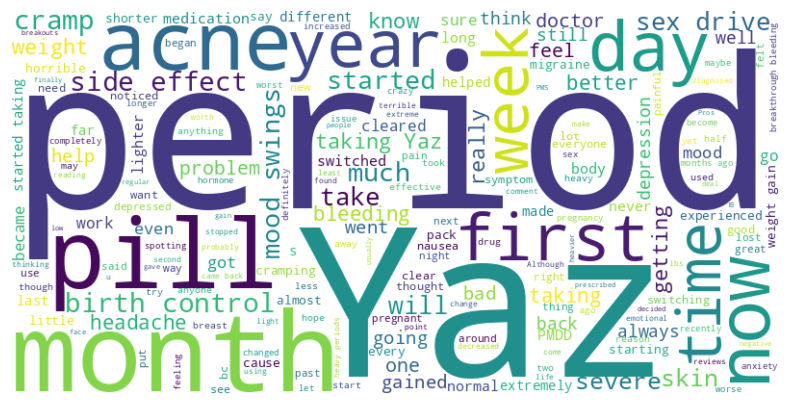

In [ ]:
reviews_0 = df[df['Final Label'] == 0]['Review']
text = ' '.join(review for review in reviews_0)

wordcloud = WordCloud(width=800, height=400, background_color='white')
word_freq = wordcloud.process_text(text)

top_15_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]
top_15_words = [word for word, freq in top_15_words]

print("Top 15 frequent words:", top_15_words)

wordcloud.generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
stopwords_list = [word for word in top_15_words if word in STOP_WORDS]

print("Stopwords in top 15 frequent words:", stopwords_list)

Stopwords in top 15 frequent words: []


In [ ]:
words_to_check = ["but", "although", "however","nevertheless"]

stopwords_found = [word for word in words_to_check if word in STOP_WORDS]

print("Stopwords found:", stopwords_found)

Stopwords found: ['but', 'although', 'however', 'nevertheless']


In [ ]:
stopwords_list.extend(stopwords_found)
print(stopwords_list)
print(len(STOP_WORDS))
for word in stopwords_list:
    STOP_WORDS.remove(word)
print(len(STOP_WORDS))

['but', 'although', 'however', 'nevertheless']
323
319


### Distribution of Labels

In [ ]:
value_counts = df['Final Label'].value_counts()
percentages = df['Final Label'].value_counts(normalize=True) * 100


value_counts_df = pd.DataFrame({'Value Counts': value_counts})
percentages_df = pd.DataFrame({'Percentages (%)': percentages})

result_df = pd.concat([value_counts_df, round(percentages_df,2)], axis=1)

print(result_df)

             Value Counts  Percentages (%)
Final Label                               
-1.0                  387            53.53
 1.0                  225            31.12
 0.0                  111            15.35


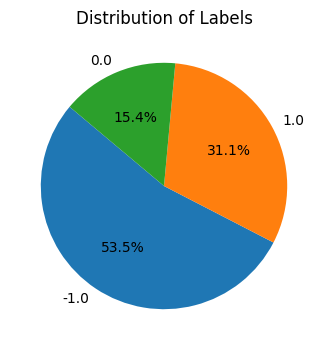

In [ ]:
plt.figure(figsize=(4, 4))
percentages.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Labels")
plt.ylabel('')
plt.show()

### Data Cleaning

In [ ]:
nlp = spacy.load("en_core_web_sm")
#print(len(nlp.Defaults.stop_words))
def clean_text(text):
    text = text.lower()
    tokens = nlp(text)
    clean_tokens = [token.text for token in tokens if token.text not in STOP_WORDS and token.text not in string.punctuation]
    #clean_tokens = [token.text for token in tokens if token.text not in string.punctuation]
    clean_text = ' '.join(clean_tokens)
    return clean_text
df['final_review'] = df['Review'].apply(clean_text)
print(df.shape)

(723, 16)


In [ ]:
import spacy
import string

nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = text.lower()
    doc = nlp(text)
    clean_tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and token.text not in string.punctuation]
    clean_text = ' '.join(clean_tokens)
    return clean_text

df['final_review'] = df['Review'].apply(clean_text)
print(df.shape)


(723, 16)


In [ ]:
df[['Review', 'Final Label']].rename(columns={'Review': 'text', 'Final Label': 'labels'}).to_csv('YAZ_v_3.csv', index=False)
from google.colab import files
files.download('YAZ_v_3.csv')
df.sample(3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Review,Condition,Overall Ratings,Effectiveness,Ease of Use,Satisfaction,Rachel,Longyang,Lu,Ibrahim,Aleyeh,Label 1,Label 2,Label 3,Final Label,final_review
234,I used Yaz for one year. The first four months...,Other,3.3,4,5,2,NaN,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,I use yaz year first month I absolutlely thril...
495,This pill made me gain 10 to 15 lbs and made m...,Acne,5.0,4,3,1,-1.0,NaN,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0,pill I gain 10 15 lbs I loss sex drive I like ...
667,im more fatigue since taking this pill,Birth Control,4.0,3,4,2,0.0,-1.0,NaN,-1.0,NaN,0.0,-1.0,-1.0,-1.0,I m fatigue pill


### Feature Extraction

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['final_review'])
y = df['Final Label']
svm_classifier = SVC()
X_train, X_test, y_train, y_test = train_test_split(df['final_review'], y, test_size=0.2, random_state=42)

### Ignore Everything Below - Just Exploring Traditional ML models

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', LinearSVC())
])

parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [1, 10, 100],
    #'svm__gamma': ['scale', 'auto'],
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'svm__C': 1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}
Best score: 0.7267016491754122


In [ ]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))

print("Confusion Matrix:\n", )
svm_conf_matrix = confusion_matrix(y_test, predictions)
svm_conf_matrix
labels = sorted(set(y_test))
svm_conf_df = pd.DataFrame(svm_conf_matrix, index=labels, columns=labels)
svm_conf_df

Accuracy: 0.7655172413793103
Confusion Matrix:



,-1.0,0.0,1.0
-1.0,73,1,3
0.0,11,1,8
1.0,9,2,37


In [ ]:
class_report = classification_report(y_test, predictions)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

        -1.0       0.78      0.95      0.86        77
         0.0       0.25      0.05      0.08        20
         1.0       0.77      0.77      0.77        48

    accuracy                           0.77       145
   macro avg       0.60      0.59      0.57       145
weighted avg       0.71      0.77      0.72       145



In [ ]:
best_model.predict([''])

array([-1.])

In [ ]:
X_test

336          worked effects liked quick painless periods
517    started yaz 1 1/2 months ago severe headaches ...
598    easy use pill everyday good pill   lots effect...
33     spot bleeding month went away irritability mig...
439    began taking 2yrs ago 6 months year worked fab...
                             ...                        
382    ending month yaz come hate constantly tired en...
328    taking yaz 2 years 10 months straight point no...
568    medication 6 years loved   acne weight gain bo...
429    effects experienced yaz month horrible acne co...
136    stopped taking yaz     menopausal symptoms tho...
Name: final_review, Length: 145, dtype: object

In [ ]:
final_df=pd.DataFrame({'Review':df['final_review'],'Label':df['Final Label']})

In [ ]:
excel_file_path = "/content/YAZ.xlsx"
final_df.to_excel(excel_file_path, index=False)

### Handling Data Imbalance

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_text = tfidf_vectorizer.fit_transform(df['final_review'])

# Split data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, df['Final Label'], test_size=0.2, random_state=42)

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_text, y_train)

# Now you have balanced training data
print("Class distribution after SMOTE on training data:", Counter(y_train_resampled))

Class distribution after SMOTE on training data: Counter({-1.0: 310, 1.0: 310, 0.0: 310})


### Clustering


Null counts for each column:
Effectiveness    0
Ease of Use      0
Satisfaction     0
dtype: int64
Cluster
0    362
1    317
2     44
Name: count, dtype: int64


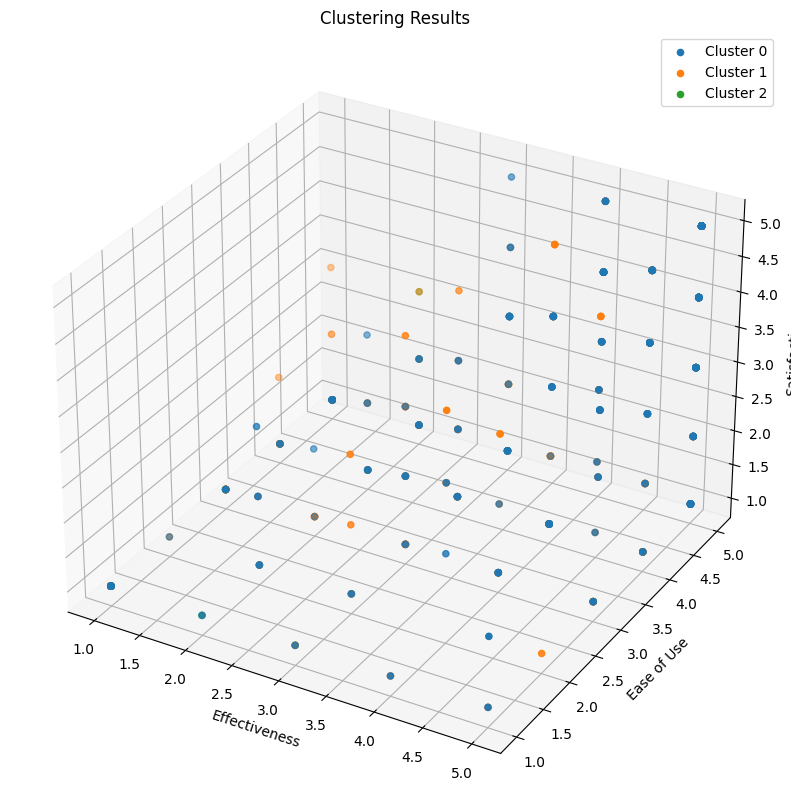

In [ ]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

null_counts = df[["Effectiveness", "Ease of Use", "Satisfaction"]].isnull().sum()

print("Null counts for each column:")
print(null_counts)

data = df[["Overall Ratings"]]

agg_clustering = AgglomerativeClustering(n_clusters=3)

labels = agg_clustering.fit_predict(data)

df['Cluster'] = labels

print(df['Cluster'].value_counts())

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for cluster_label in range(3):
    cluster_data = df[df['Cluster'] == cluster_label]
    ax.scatter(cluster_data['Effectiveness'], cluster_data['Ease of Use'], cluster_data['Satisfaction'], label=f'Cluster {cluster_label}')

ax.set_xlabel('Effectiveness')
ax.set_ylabel('Ease of Use')
ax.set_zlabel('Satisfaction')
ax.set_title('Clustering Results')

ax.legend()

plt.show()


In [ ]:
!pip install vaderSentiment
!pip install pandas

import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply the sentiment analyzer to each review and extract the sentiment score and label
def get_sentiment(review):
    scores = analyzer.polarity_scores(review)
    score = scores['compound']
    if score >= 0.05:
        label = 'Positive'
    elif score <= -0.05:
        label = 'Negative'
    else:
        label = 'Neutral'
    return score, label

# Load your DataFrame (assuming it's already loaded as 'df')
# Assuming 'Review' column contains the reviews
# Apply sentiment analysis and store results in new columns
df['Sentiment Score'], df['Sentiment Label'] = zip(*df['Review'].apply(get_sentiment))

# Save DataFrame to an Excel file
df.to_excel('sentiment_analysis_results.xlsx', index=False)


In [ ]:
from google.colab import files

files.download('sentiment_analysis_results.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>